# *CGH optimization with phase-only slm*
Comparing `CGH` optimization techniques, including `Gerchberg-Saxton` (GS), `Stochastic Gradient Descent` (SGD) and `Adaptive Moment Estimation` (ADAM).

In this code, We repeat Tutorial 2.2 with optimizing `phase only SLM`(not complex SLM).

In [ ]:
cd ../..

---

## 🌊 **Step 1: Import Pado**
First, you should import `Pado`. Make sure to install all the dependency

In [1]:
import pado
from pado.math import cm, nm, um
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

## ⚙️ **Step 2: Default value setting**
Sets the values of the variables used in the code. You can change the values in this part to suit your situation.

In [2]:
R = 1080  # number of rows
C = 1920  # number of columns
pitch = 6.4 * um  # physical size of each pixel in [m]
wvl = [660 * nm, 521 * nm, 445 * nm]  # wavelength of the light in [m]
dim = (1, 3, R, C)  # dimension of the light [batch, channel, row, column]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
prop = pado.propagator.Propagator('ASM')

dist = 15 * cm  # distance of the propagation in [m]

##  **🤖 Step 3: Implementation of CGH optimization algorithms**
Create an algorithm for `CGH optimization`. `Mode` variable is used to proceed with optimization in each way of `GS`, `SGD`, and `ADAM`.    
 Performance is evaluated by `psnr`.

We modify the IterativeCGH class to enforce `phase-only` constraints during optimization. After each iteration or gradient update, we set the SLM field's amplitude to 1 and retain only the phase.

In [ ]:
class IterativeCGH:
    def __init__(self, mode):
        """Create CGH optimization instance for phase-only SLM
        
        Args:
            mode (str): Algorithm type - one of "GS", "SGD", or "ADAM"
        """
        self.mode = mode

    def optimize(self, light, target, z, n_iter=100, prop_model='ASM'):
        """Optimize light field phase to match target intensity pattern for phase-only SLM
        
        Args:
            light (Light): Input light field
            target (Light): Target intensity pattern  
            z (float): Propagation distance in meters
            n_iter (int): Number of iterations (default: 100)
            prop_model (str): Propagation model (default: 'ASM')
        """
        if self.mode == "GS":
            return self.gerchberg_saxton(light, target, z, n_iter, prop_model)
        elif self.mode == "SGD":
            return self.stochastic_gradient_descent(light, target, z, n_iter, prop_model)
        elif self.mode == "ADAM":
            return self.adaptive_moment_estimation(light, target, z, n_iter, prop_model)

    def gerchberg_saxton(self, init_light, target_light, z, n_iter=100, prop_model='ASM'):
        """Implementation of Gerchberg-Saxton phase retrieval algorithm for phase-only SLM"""
        slm_field = init_light.clone()
        prop = pado.propagator.Propagator(prop_model)

        print("Using Gerchberg-Saxton (GS) algorithm")
        for i in range(n_iter):
            if i % 10 == 0:
                psnr = pado.math.calculate_psnr(prop.forward(slm_field, -z).get_intensity(), target_light.get_intensity())
                print(f"Iteration {i}, PSNR: {psnr:.2f}")

            # Enforce phase-only constraint at the SLM plane
            slm_field = self.set_amplitude_ones(slm_field)

            # Propagate to the target plane
            recon_field = prop.forward(slm_field, -z)
            # Replace amplitude with target amplitude, keep phase
            recon_field.set_amplitude(target_light.get_amplitude())
            # Propagate back to the SLM plane
            slm_field = prop.forward(recon_field, z)

        # Final phase-only constraint
        slm_field = self.set_amplitude_ones(slm_field)
        print("===========================================================")
        return slm_field

    def stochastic_gradient_descent(self, init_light, target_light, z, n_iter=100, prop_model='ASM', lr=1000000):
        """Implementation of SGD-based phase optimization for phase-only SLM"""
        slm_field = init_light.clone()
        prop = pado.propagator.Propagator(prop_model)
        target_amp = target_light.get_amplitude().detach()

        # Optimize only the phase (we'll extract and apply phase-only constraint)
        phase = torch.angle(slm_field.field).requires_grad_(True)
        optimizer = optim.SGD([phase], lr=lr)
        loss_fn = nn.MSELoss()

        print("Using Stochastic Gradient Descent (SGD) algorithm")
        for i in range(n_iter):
            optimizer.zero_grad()

            # Create phase-only SLM field
            slm_field.field = torch.exp(1j * phase)
            slm_field = self.set_amplitude_ones(slm_field)  # Use the specified method to set amplitude to 1

            recon_field = prop.forward(slm_field, -z)
            recon_amp = recon_field.get_amplitude()
            loss = loss_fn(recon_amp, target_amp)
            loss.backward()
            optimizer.step()

            # Update phase (already handled by optimizer)
            if i % 10 == 0:
                psnr = pado.math.calculate_psnr(prop.forward(slm_field, -z).get_intensity(), target_light.get_intensity())
                print(f"Iteration {i}, PSNR: {psnr:.2f}")

        # Final phase-only field
        slm_field.field = torch.exp(1j * phase)
        slm_field = self.set_amplitude_ones(slm_field)  # Use the specified method to set amplitude to 1
        print("===========================================================")
        return slm_field

    def adaptive_moment_estimation(self, init_light, target_light, z, n_iter=100, prop_model='ASM', lr=1e-1):
        """Implementation of ADAM optimization for phase-only SLM"""
        slm_field = init_light.clone()
        prop = pado.propagator.Propagator(prop_model)
        target_amp = target_light.get_amplitude().detach()

        # Optimize only the phase
        phase = torch.angle(slm_field.field).requires_grad_(True)
        optimizer = optim.Adam([phase], lr=lr)
        loss_fn = nn.MSELoss()

        print("Using Adaptive Moment Estimation (ADAM) algorithm")
        for i in range(n_iter):
            optimizer.zero_grad()

            # Create phase-only SLM field
            slm_field.field = torch.exp(1j * phase)
            slm_field = self.set_amplitude_ones(slm_field)  # Use the specified method to set amplitude to 1

            recon_field = prop.forward(slm_field, -z)
            recon_amp = recon_field.get_amplitude()
            loss = loss_fn(recon_amp, target_amp)
            loss.backward()
            optimizer.step()
            if i % 10 == 0:
                psnr = pado.math.calculate_psnr(prop.forward(slm_field, -z).get_intensity(), target_light.get_intensity())
                print(f"Iteration {i}, PSNR: {psnr:.2f}")

        # Final phase-only field
        slm_field.field = torch.exp(1j * phase)
        slm_field = self.set_amplitude_ones(slm_field)  # Use the specified method to set amplitude to 1
        print("===========================================================")
        return slm_field

##  **🖼️ Step 4: Build objectplane**
Load an example image for CGH optimization.    
This image becomes the ground truth we want to rebuild.

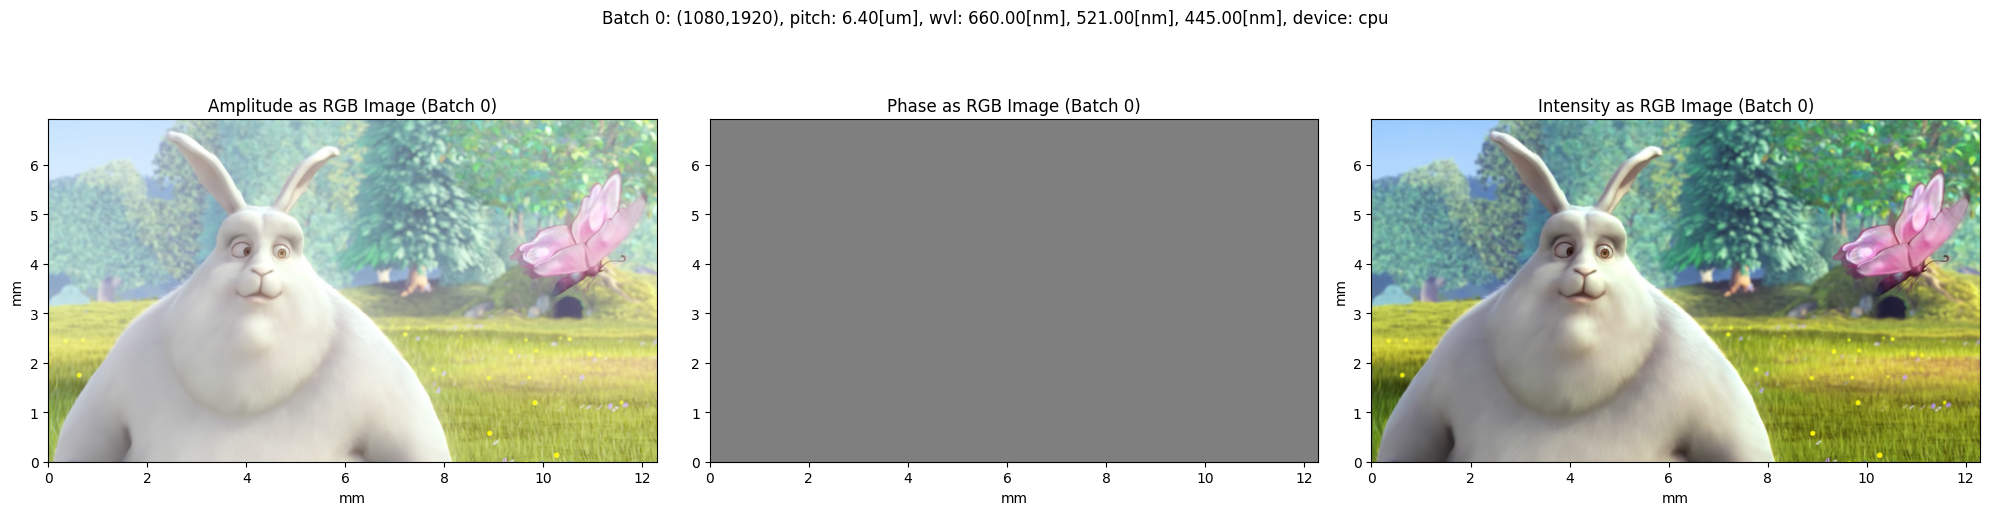

In [4]:
# Load the target image into the object plane
object_plane = pado.light.Light(dim, pitch, wvl, device=device)
object_plane.load_image(r'../asset/bunny.PNG', random_phase=False)
object_plane.visualize_image()

##  **🤖 Step 5: Activate optimizer and set slm plane**
Set up the SLM plane. Then, optimize the SLM plane using the modified algorithms for a phase-only SLM.

In [ ]:
# Create optimizers for each method
GS_optimizer = IterativeCGH(mode="GS")
SGD_optimizer = IterativeCGH(mode="SGD")
ADAM_optimizer = IterativeCGH(mode="ADAM")

# Original SLM plane (propagate from object plane to SLM plane)
SLM_plane = prop.forward(object_plane, dist)

# Make the initial SLM field phase-only
SLM_plane = GS_optimizer.set_amplitude_ones(SLM_plane)

# Optimize the SLM plane with the indoor image using each method
GS_optimized = GS_optimizer.optimize(SLM_plane, object_plane, dist, n_iter=30)
SGD_optimized = SGD_optimizer.optimize(SLM_plane, object_plane, dist, n_iter=200)
ADAM_optimized = ADAM_optimizer.optimize(SLM_plane, object_plane, dist, n_iter=200)

Using Gerchberg-Saxton (GS) algorithm
Iteration 0, PSNR: 6.05
Iteration 10, PSNR: 31.63
Iteration 20, PSNR: 30.81
Using Stochastic Gradient Descent (SGD) algorithm
Iteration 0, PSNR: 6.05
Iteration 10, PSNR: 6.52
Iteration 20, PSNR: 6.72
Iteration 30, PSNR: 7.19
Iteration 40, PSNR: 8.20
Iteration 50, PSNR: 9.42
Iteration 60, PSNR: 10.82
Iteration 70, PSNR: 12.48
Iteration 80, PSNR: 14.30
Iteration 90, PSNR: 16.18
Iteration 100, PSNR: 18.05
Iteration 110, PSNR: 19.82
Iteration 120, PSNR: 21.45
Iteration 130, PSNR: 22.89
Iteration 140, PSNR: 24.12
Iteration 150, PSNR: 25.15
Iteration 160, PSNR: 26.01
Iteration 170, PSNR: 26.73
Iteration 180, PSNR: 27.33
Iteration 190, PSNR: 27.85
Using Adaptive Moment Estimation (ADAM) algorithm
Iteration 0, PSNR: 6.05
Iteration 10, PSNR: 6.77
Iteration 20, PSNR: 9.32
Iteration 30, PSNR: 15.12
Iteration 40, PSNR: 19.92
Iteration 50, PSNR: 23.11
Iteration 60, PSNR: 25.87
Iteration 70, PSNR: 28.03
Iteration 80, PSNR: 29.57
Iteration 90, PSNR: 30.69
Iterati

##  **🎖️ Step 6: Compare optimization result**
Compare the optimization results with each algorithm, which is evaluated through the `psnr` score.

Original Reconstruction PSNR: 6.053947448730469 dB


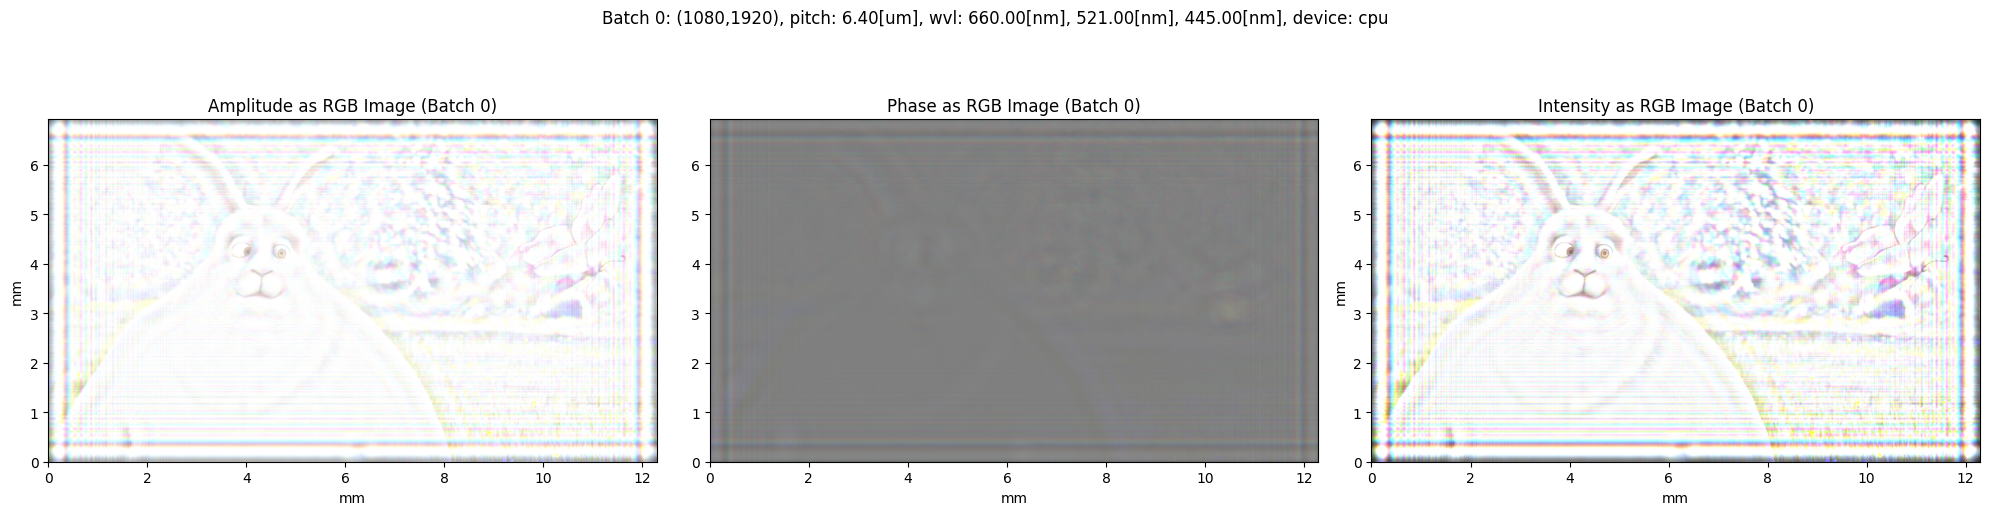

GS Reconstruction PSNR: 6.068137168884277 dB


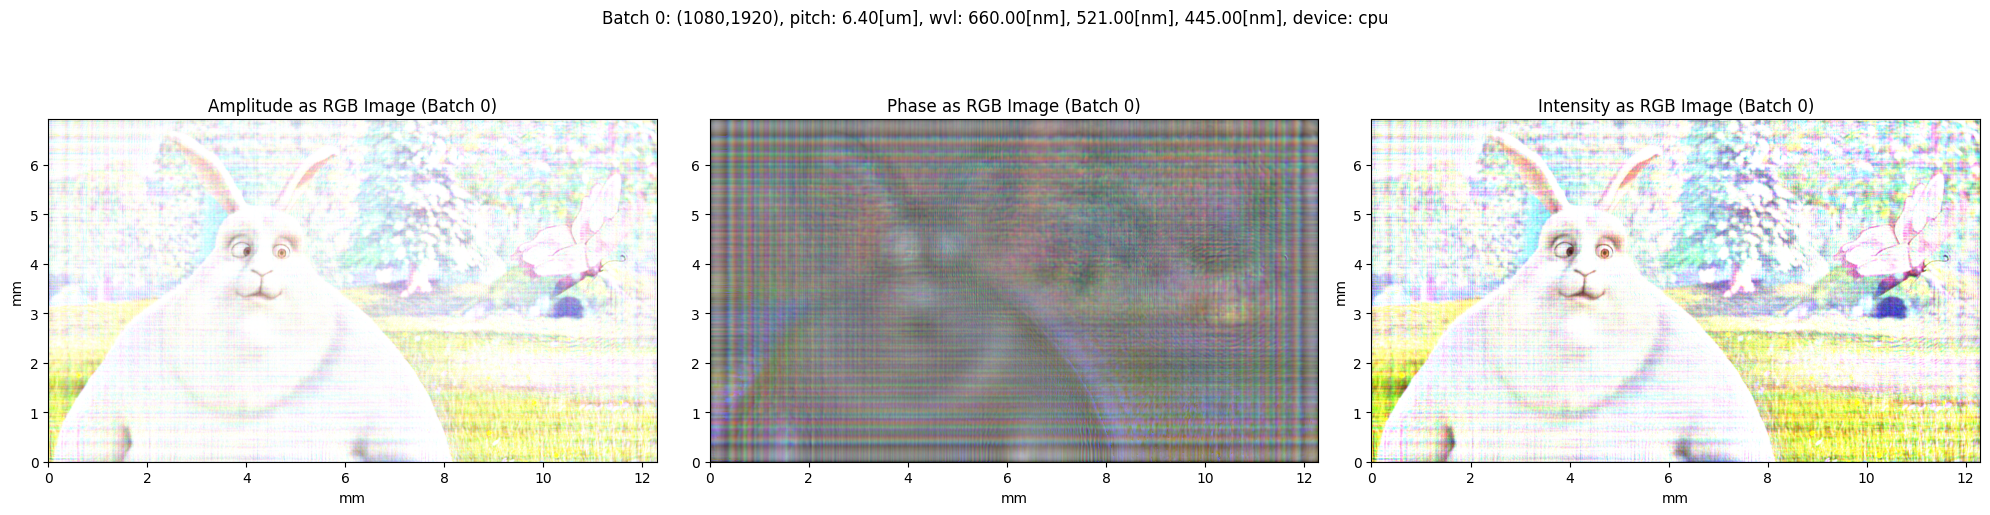

SGD Reconstruction PSNR: 28.29509925842285 dB


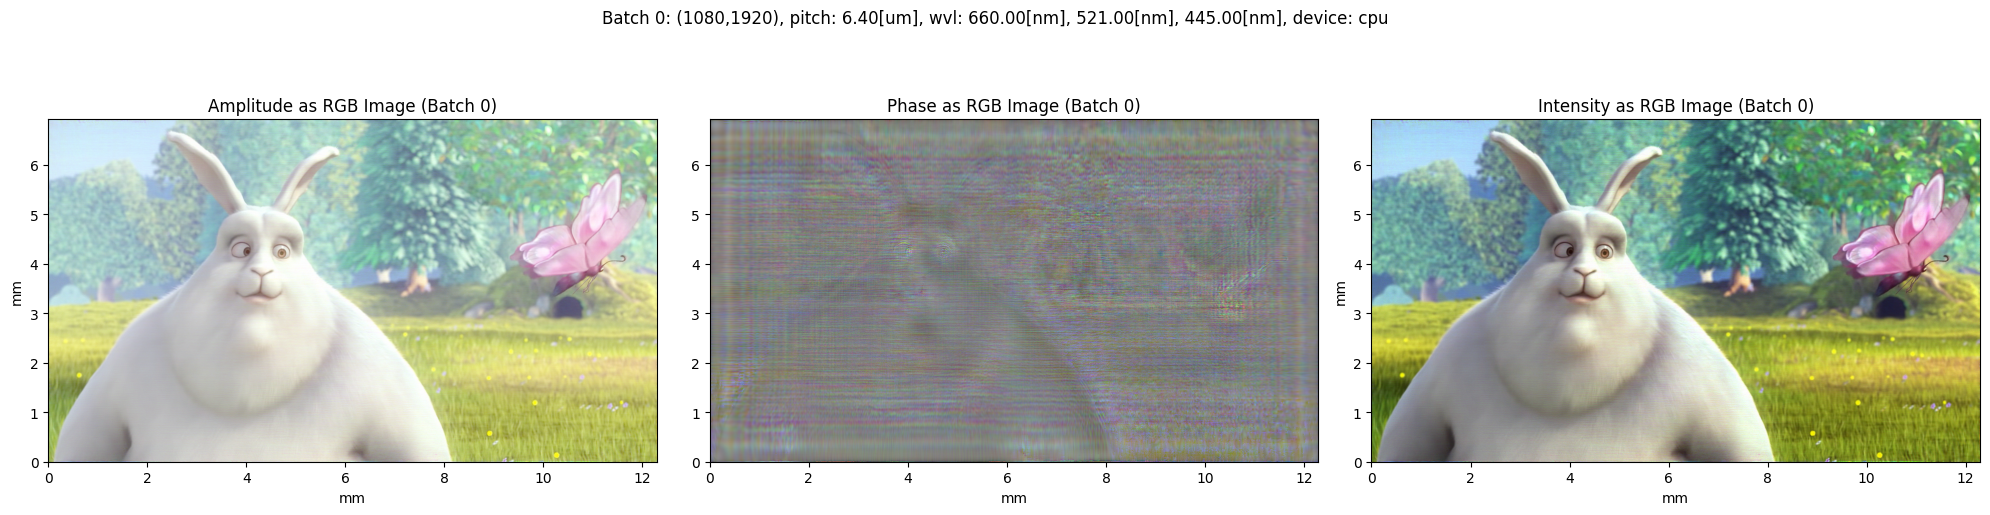

ADAM Reconstruction PSNR: 35.191810607910156 dB


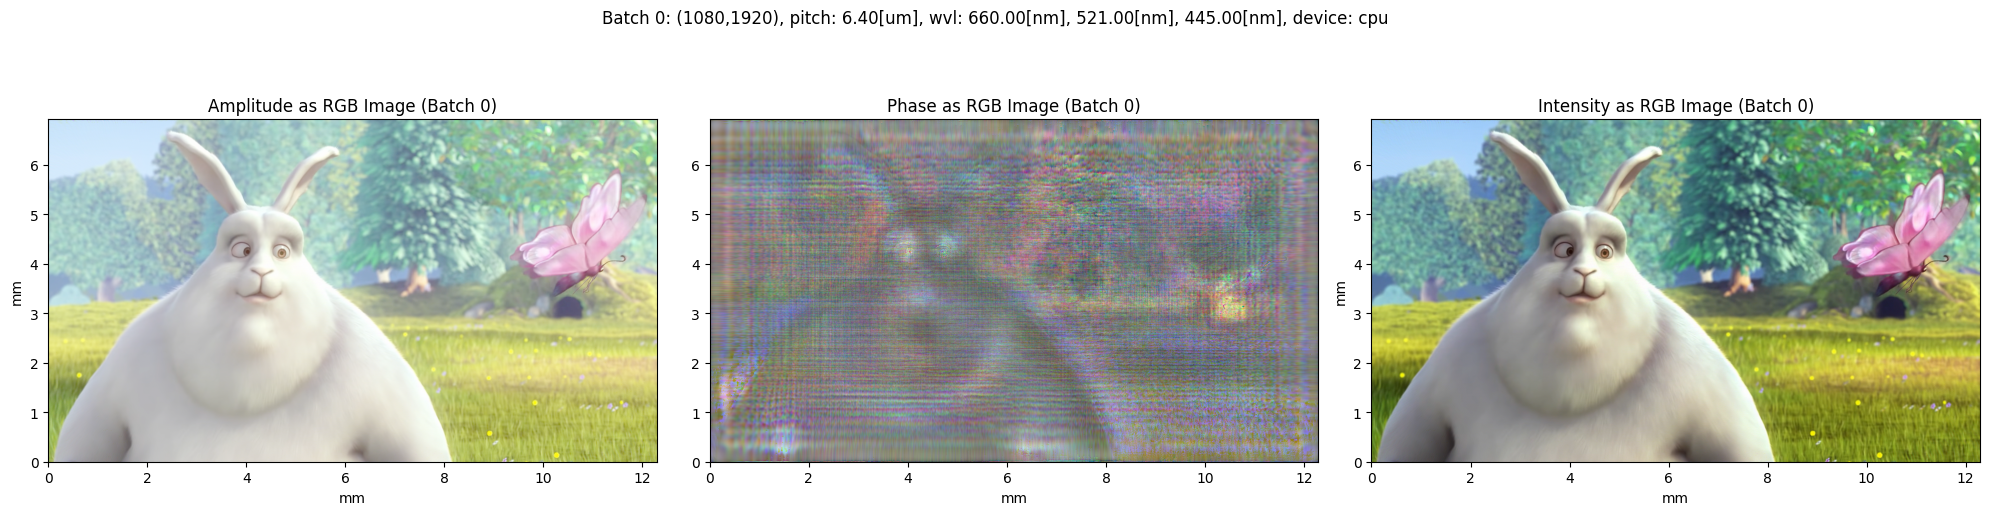

In [15]:
# Reconstruction of the optimized image
original_reconstruction = prop.forward(SLM_plane, -dist)
GS_reconstruction = prop.forward(GS_optimized, -dist)
SGD_reconstruction = prop.forward(SGD_optimized, -dist)
ADAM_reconstruction = prop.forward(ADAM_optimized, -dist)

# PSNR calculation and visualization
print("Original Reconstruction PSNR: {} dB".format(pado.math.calculate_psnr(object_plane.get_intensity(), original_reconstruction.get_intensity())))
original_reconstruction.visualize_image()

print("GS Reconstruction PSNR: {} dB".format(pado.math.calculate_psnr(object_plane.get_intensity(), GS_reconstruction.get_intensity())))
GS_reconstruction.visualize_image()

print("SGD Reconstruction PSNR: {} dB".format(pado.math.calculate_psnr(object_plane.get_intensity(), SGD_reconstruction.get_intensity())))
SGD_reconstruction.visualize_image()

print("ADAM Reconstruction PSNR: {} dB".format(pado.math.calculate_psnr(object_plane.get_intensity(), ADAM_reconstruction.get_intensity())))
ADAM_reconstruction.visualize_image()